In [1]:
import numpy as np
import xarray as xr
from skimage.morphology import medial_axis
from matplotlib import pyplot as plt
%matplotlib inline

In [24]:
from skimage.morphology import medial_axis

def plot_width(PIV_masked,pathx,pathy,ind,ax,label,color='w'):

    # x and y in physical coordinates
    x1 = PIV_masked.x[pathx[ind]].values
    y1 = PIV_masked.y[pathy[ind]].values
    
    # finds local derivative
    ind2 = np.argmin((np.append(pathx[:ind],pathx[ind+1:])-pathx[ind])**2 + (np.append(pathy[:ind],pathy[ind+1:])-pathy[ind])**2)
    x2 = PIV_masked.x[np.append(pathx[:ind],pathx[ind+1:])[ind2]].values
    y2 = PIV_masked.y[np.append(pathy[:ind],pathy[ind+1:])[ind2]].values
    
    # scale to channel width
    a = PIV_masked.centerline[pathx[ind],pathy[ind]].values/2/np.sqrt((x2-x1)**2+(y2-y1)**2)
    
    # plots width
    ax.plot(a*np.array([x2-x1,x1-x2])+y1,a*np.array([y1-y2,y2-y1])+x1,color,label=label)
    return ax

def lava_width(PIV_masked,quantile=1.0,thresh=0.2,min_dist=2):
    """ lava_area calulates the area of the lava flow in meters squared
     
    INPUTS: 
    PIV_masked: Local path to masked_PIV file (.nc format)
    
    Optional Parameters:
    quantile: float between 0-1, to reduce noisey spikes, selects the % highest velocity
    thresh: determines change in sign for derivative of distance function, increase to remove branches, decrease if holes
    min_dist: minimum number of pixels away from the channel edges to be part of center line

    OUTPUTS: Width and length of channel boundaries in meters
    """
    # open masked dataset
    if type(PIV_masked) == xr.core.dataarray.DataArray:
        PIV_masked = PIV_masked
        #type(PIV_masked) ==  xr.core.dataset.Dataset
    else:
        PIV_masked = xr.open_dataset(PIV_masked)
        PIV_masked = PIV_masked.__xarray_dataarray_variable__.rename('s')

    mask = PIV_masked.where(PIV_masked == 0).fillna(value=1)
    mask2 = mask.rename('s'=='m')
    PIV_masked['mask']= mask2

    #find pixel size in meters
    pixX = (PIV_masked.x[1] - PIV_masked.x[0]).values
    pixY = (PIV_masked.y[1] - PIV_masked.y[0]).values

    # Compute the medial axis (skeleton) and the distance transform
    skel, distance = medial_axis(mask, return_distance=True)

    # calculate first derivatves
    dist_dx = (distance[:,:-2] - distance[:,2:])/2
    dist_dy = (distance[:-2,:] - distance[2:,:])/2
    
    # find regions where first derivative changes sign
    max_x = (dist_dx[:,:-2]<-thresh)&(dist_dx[:,2:]>thresh)
    max_y = (dist_dy[:-2,:]<-thresh)&(dist_dy[2:,:]>thresh)

    # find where skeleton is at local maxima, at least two pixels from edge
    new_skeleton = np.zeros_like(skel)
    new_skeleton[2:-2,2:-2] = ((max_x[2:-2,:]|max_y[:,2:-2])&(distance[2:-2,2:-2]>min_dist))*skel[2:-2,2:-2]
    dist_on_skeleton = distance*new_skeleton*2*pixX
    PIV_masked['centerline'] = xr.DataArray(dist_on_skeleton, dims = ['x','y'])

    # plot results
    fig, ax = plt.subplots(figsize=(12,12))
    PIV_masked.plot(ax=ax,cmap='magma')
    PIV_masked.mask.plot.contour(levels=1,yincrease=False, cmap ='white',ax=ax)

    # convert to list of points on skeleton
    pathx, pathy = np.nonzero(new_skeleton)
    ax.scatter(PIV_masked.y[pathy],PIV_masked.x[pathx],100,dist_on_skeleton[pathx,pathy],cmap='Reds')
    
    # find maximum velocity
    maxXYq = PIV_masked.where(PIV_masked<PIV_masked.quantile(quantile), drop=True).squeeze()
    maxXY =  maxXYq.where(maxXYq==maxXYq.max(), drop=True).squeeze()
    ind = np.argmin((PIV_masked.x.values[pathx]-maxXY.x.values)**2 + (PIV_masked.y.values[pathy]-maxXY.y.values)**2)

    # print statements on channel widths
    print('mean width:', round(np.mean(dist_on_skeleton[dist_on_skeleton>0]),1), 'm')
    print('width at max velocity:', round(dist_on_skeleton[pathx[ind],pathy[ind]],1), 'm')
    print('max width:', round(np.max(dist_on_skeleton),1), 'm')
    print('min width:', round(np.min(dist_on_skeleton[dist_on_skeleton>0]),1), 'm')

    # plot widths at interesting points
    plot_width(PIV_masked,pathx,pathy,np.argmax(dist_on_skeleton[dist_on_skeleton>0]),ax,'Maximum width','w')
    plot_width(PIV_masked,pathx,pathy,ind,ax,'Width at max velocity','b')
    plot_width(PIV_masked,pathx,pathy,np.argmin(dist_on_skeleton[dist_on_skeleton>0]),ax,'Minimum width','r')

    ax.set_aspect('equal')
    ax.legend()
    return ()
   

mean width: 82.2 m
width at max velocity: 118.4 m
max width: 157.4 m
min width: 21.8 m


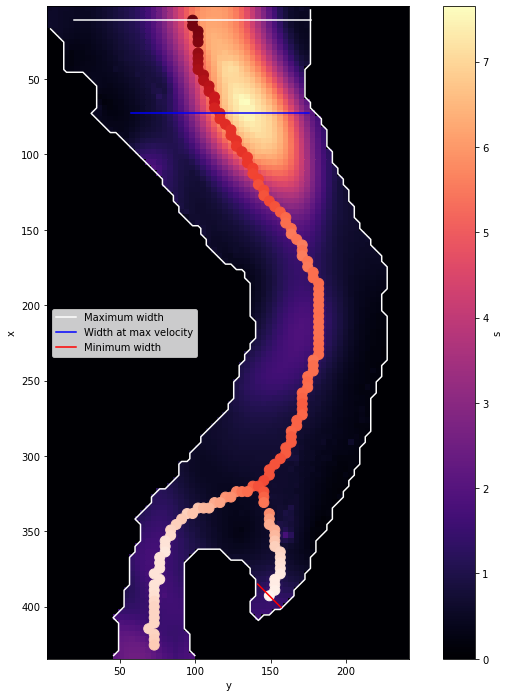

In [4]:
PIV_maskedH = '/Volumes/KLERZ_Vel/Sites/Site2/0714/20180714_Vel_Pt2_0350_304.8mAG_masked_mean.nc'
lava_width(PIV_maskedH)

mean width: 293.4 m
width at max velocity: 303.8 m
max width: 489.9 m
min width: 156.4 m


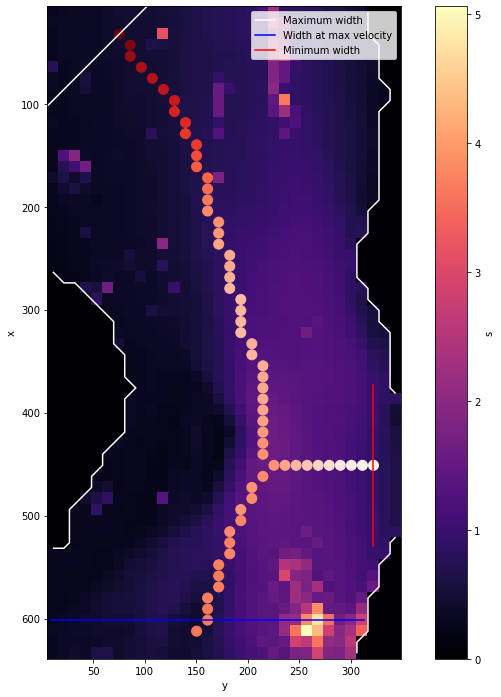

In [17]:
PIV_masked6 = '/Volumes/KLERZ_Vel/Sites/Site6/0727/DJI_0002_20180727_velpt6_2010_TRIM_450.1mAG_masked_mean.nc'
lv = lava_width(PIV_masked6, quantile=.97)

In [18]:
plt.lv

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

mean width: 93.9 m
width at max velocity: 84.7 m
max width: 131.0 m
min width: 71.9 m


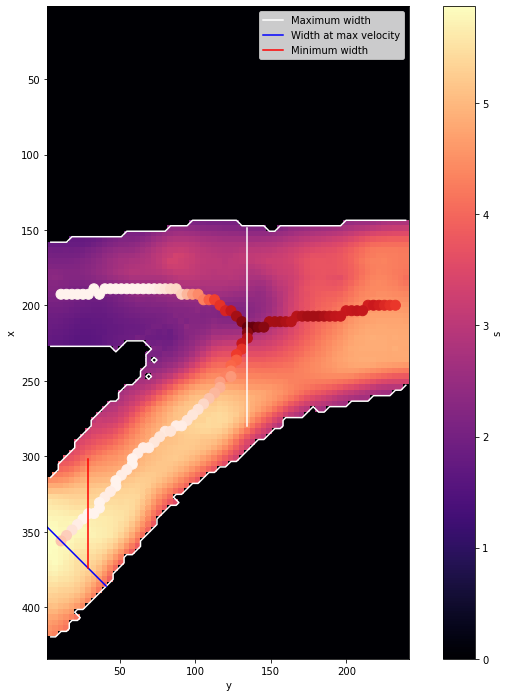

In [11]:
PIV_mask8 ='/Volumes/KLERZ_Vel/Sites/Site8/0717/DJI_0004_20180717_0427_vel8_304.5mAG_masked_mean.nc'
lava_width(PIV_mask8)

mean width: 89.9 m
width at max velocity: 72.7 m
max width: 117.2 m
min width: 72.7 m


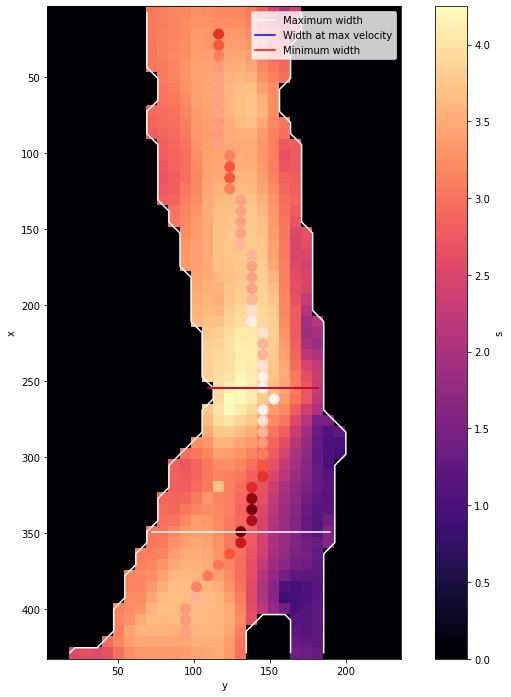

In [12]:
mask13 = '/Volumes/KLERZ_Vel/Sites/Site13/0720/DJI_0004_20180720_vel13_0309_TRIM_304.7mAG_masked_mean.nc'
lava_width(mask13)